# Feed-forward neural network

<img src="ff_nn.jpeg">

Давайте вспомним, что такое нейронные сети прямого распространения. 

Нейронные сети прямого распространения (feed forward neural networks, FF или FFNN) и перцептроны (perceptrons, P) очень прямолинейны, они передают информацию от входа к выходу. Нейронные сети часто описываются в виде слоёного торта, где каждый слой состоит из входных, скрытых или выходных клеток. Клетки одного слоя не связаны между собой, а соседние слои обычно полностью связаны. Самая простая нейронная сеть имеет две входных клетки и одну выходную, и может использоваться в качестве модели логических вентилей. FFNN обычно обучается по методу обратного распространения ошибки, в котором сеть получает множества входных и выходных данных. Этот процесс называется обучением с учителем, и он отличается от обучения без учителя тем, что во втором случае множество выходных данных сеть составляет самостоятельно. Вышеупомянутая ошибка является разницей между вводом и выводом. Если у сети есть достаточное количество скрытых нейронов, она теоретически способна смоделировать взаимодействие между входным и выходными данными. Практически такие сети используются редко, но их часто комбинируют с другими типами для получения новых.

По сути - это последовательность матричных умножений

К выходу сети применяется функция активации

<img src="activations.png">

In [1]:
import torch
import numpy as np

from torch import nn
import torchvision

In [2]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(1,1)
        print(self.fc)
        self.relu = nn.ReLU()

    def forward(self, x):
        print(x)
        output = self.fc(x)
        print(output)
        output = self.relu(output)
        print(output)
        return output

In [3]:
perc = Perceptron()
print(perc)

Linear(in_features=1, out_features=1, bias=True)
Perceptron(
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (relu): ReLU()
)


In [4]:
# Так выглядит инференс нейронной сети по входным данным
perc(torch.FloatTensor([5])), perc(torch.FloatTensor([-15]))

tensor([5.])
tensor([5.2861], grad_fn=<AddBackward0>)
tensor([5.2861], grad_fn=<ReluBackward0>)
tensor([-15.])
tensor([-14.1400], grad_fn=<AddBackward0>)
tensor([0.], grad_fn=<ReluBackward0>)


(tensor([5.2861], grad_fn=<ReluBackward0>),
 tensor([0.], grad_fn=<ReluBackward0>))

In [6]:
perc.fc.weight, perc.fc.bias

(Parameter containing:
 tensor([[0.9713]], requires_grad=True), Parameter containing:
 tensor([0.4295], requires_grad=True))

# Посмотрим на более сложную архитектуру

In [7]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [8]:
import torch.nn.functional as F

In [9]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.fc2 = Perceptron(hidden_dim, 1, "sigmoid")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        print(x)
        return x

In [10]:
from sklearn.datasets import make_blobs

def blob_label(y, label, loc): # assign labels
    target = np.copy(y)
    for l in loc:
        target[y == l] = label
    return target

x_train, y_train = make_blobs(n_samples=40, n_features=2, cluster_std=1.5, shuffle=True)
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(blob_label(y_train, 0, [0]))
y_train = torch.FloatTensor(blob_label(y_train, 1, [1,2,3]))

x_test, y_test = make_blobs(n_samples=10, n_features=2, cluster_std=1.5, shuffle=True)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(blob_label(y_test, 0, [0]))
y_test = torch.FloatTensor(blob_label(y_test, 1, [1,2,3]))

In [11]:
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


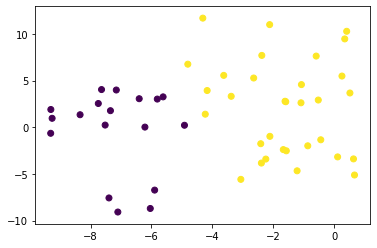

In [12]:
plt.scatter(x_train.numpy()[:, 0], x_train.numpy()[:, 1], c=y_train.numpy())
plt.scatter(x_test.numpy()[:, 0], x_test.numpy()[:, 1], c=(2+y_test.numpy()))

In [13]:
model = Feedforward(2, 5)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [17]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 0.798125147819519


In [16]:
model.train()
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 0.8775927424430847
Epoch 1: train loss: 0.8736743927001953
Epoch 2: train loss: 0.869917094707489
Epoch 3: train loss: 0.8662428855895996
Epoch 4: train loss: 0.8626517057418823
Epoch 5: train loss: 0.8591931462287903
Epoch 6: train loss: 0.8558490872383118
Epoch 7: train loss: 0.8526091575622559
Epoch 8: train loss: 0.849419891834259
Epoch 9: train loss: 0.846234142780304
Epoch 10: train loss: 0.8431030511856079
Epoch 11: train loss: 0.8400241136550903
Epoch 12: train loss: 0.8369961977005005
Epoch 13: train loss: 0.8340182304382324
Epoch 14: train loss: 0.8310623168945312
Epoch 15: train loss: 0.8281047940254211
Epoch 16: train loss: 0.8251875042915344
Epoch 17: train loss: 0.8222370147705078
Epoch 18: train loss: 0.8192795515060425
Epoch 19: train loss: 0.8163725733757019


In [67]:
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.5033034086227417


In [18]:
from torch import optim

In [19]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

In [20]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

0it [00:00, ?it/s]

100%|█████████▉| 170041344/170498071 [00:15<00:00, 12431715.65it/s]

Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


170500096it [00:29, 12431715.65it/s]                               

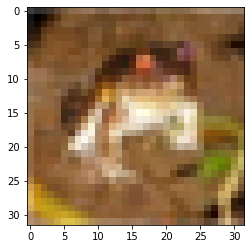

In [21]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [24]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [25]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [26]:
3 * 32 * 32

3072

In [40]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        #x = F.softmax(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [42]:
from tqdm import tqdm

In [43]:
for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')



  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 3072])


RuntimeError: size mismatch, m1: [64 x 3072], m2: [3071 x 400] at /opt/conda/conda-bld/pytorch_1573049308701/work/aten/src/TH/generic/THTensorMath.cpp:197